# All Old Taylor

Verify my methods by reproducing Figure 7 from Kay 2012 using the stored data from Ben Hillman.

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Taylor plot specific imports

In [14]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

In [4]:
from interp_functions import *

In [19]:
def calculate(cntl,test):
    """
    Calculate Taylor statistics for making taylor diagrams.
    Works with masked array if masked with NaNs.
    """
    
    _cntl = add_weights(cntl)
       
    mask = np.bitwise_or(xr.ufuncs.isnan(cntl),xr.ufuncs.isnan(test)) # mask means hide
#     mask = np.bitwise_or(cntl == np.nan,test == np.nan) # mask means hide
    
    wgt = np.array(_cntl['cell_weight'])
#     wgt = wgt * mask # does this work since one or zero?
    
    wgt = np.where(~mask,wgt,np.nan) # erroring
    
    # calculate sums and means
    # These weights are not masked, so their sum is too high.
    sumwgt = np.nansum(wgt) # this is probably where the error is. 
    meantest = np.nansum(wgt*test)/sumwgt
    meancntl = np.nansum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.nansum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.nansum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.nansum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.nansum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
        print('test: ',test.shape)
        print('meantest: ',meantest.shape)
        print('cntl: ',cntl.shape)
        print('meancntl: ',meancntl.shape)
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

In [20]:
og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'

## Panel 1 (CERES-EBAF LWCF and SWCF)

### Open files

In [21]:
og_swcf = xr.open_dataset('%s/CERES-EBAF.SWCF.nc' % (og_dir))
og_lwcf = xr.open_dataset('%s/CERES-EBAF.LWCF.nc' % (og_dir))

cam4_swcf = xr.open_dataset('%s/CAM4.SWCF.nc' % (og_dir))
cam4_lwcf = xr.open_dataset('%s/CAM4.LWCF.nc' % (og_dir))

cam5_swcf = xr.open_dataset('%s/CAM5.SWCF.nc' % (og_dir))
cam5_lwcf = xr.open_dataset('%s/CAM5.LWCF.nc' % (og_dir))

### Interpolate to observational grid

In [22]:
cam4_swcff,rgdr = interp_like2D(cam4_swcf,target=og_swcf)
cam4_lwcff,_ = interp_like2D(cam4_lwcf,regridder=rgdr)

cam5_swcff,_ = interp_like2D(cam5_swcf,regridder=rgdr)
cam5_lwcff,_ = interp_like2D(cam5_lwcf,regridder=rgdr)

#### Set-up

In [26]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'SWCFTOA': og_swcf['SWCFTOA'], # these have to be dataarrays, not datasets
        'LWCFTOA': og_lwcf['LWCFTOA'],
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'SWCFTOA':[cam4_swcff,cam5_swcff],'LWCFTOA':[cam4_lwcff,cam5_lwcff]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [28]:
varnames = ['SWCFTOA','LWCFTOA']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


### Plot

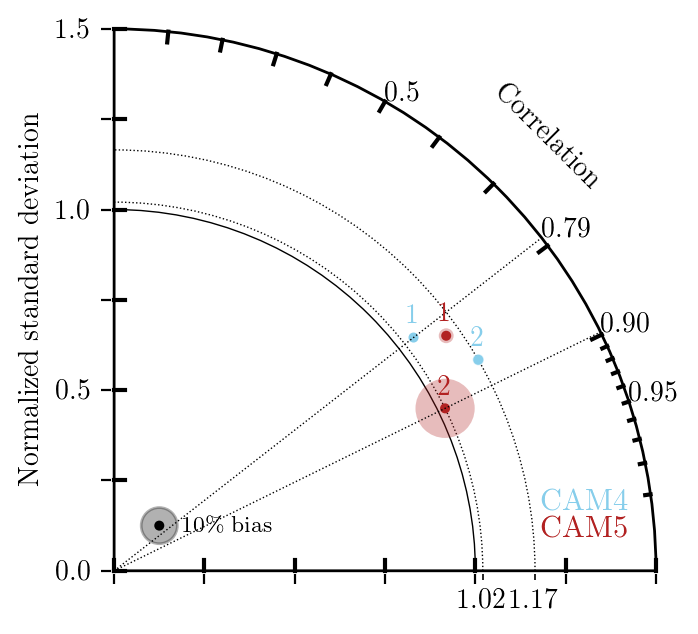

In [29]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 2 (ISCCP, MISR, and CALIPSO total cloud)

### Open files

In [30]:
os.listdir(og_dir)

['CAM4.LWCFTOA.nc',
 'CAM5.CLDLOW_CAL.nc',
 'MISR.CLDTOT_MISR.nc',
 'CERES-EBAF.SWCFTOA.nc',
 'CALIPSO.CLDHGH_CAL.nc',
 'CAM5.CLDHGH_THICK_MODIS.nc',
 'CERES-EBAF.LWCFTOA.nc',
 'CAM5.CLDTOT_MISR.nc',
 'CAM4.CLDHGH_THICK_MODIS.nc',
 'CAM5.CLDHGH_CAL.nc',
 'CERES-EBAF.LWCF.nc',
 'CAM4.CLDTOT_MISR.nc',
 'CAM5.CLDMED_CAL.nc',
 'CAM4.CLDMED_CAL.nc',
 'CAM4.CLDLOW_CAL.nc',
 'CALIPSO.CLDLOW_CAL.nc',
 'MISR.CLDLOW_THICK_MISR.nc',
 'CALIPSO.CLDTOT_CAL.nc',
 'MODIS.CLDHGH_THICK_MODIS.nc',
 'CALIPSO.CLDMED_CAL.nc',
 'CAM5.CLDLOW_THICK_MISR.nc',
 'CAM4.CLDLOW_THICK_MISR.nc',
 'CAM4.CLDTOT_ISCCPCOSP.nc',
 'CAM4.CLDTOT_CAL.nc',
 'ISCCP.CLDTOT_ISCCPCOSP.nc',
 'CAM5.CLDTOT_ISCCPCOSP.nc',
 'CAM5.LWCFTOA.nc',
 'CAM5.SWCF.nc',
 'CAM5.SWCFTOA.nc',
 'CERES-EBAF.SWCF.nc',
 'CAM5.LWCF.nc',
 'CAM4.LWCF.nc',
 'CAM4.SWCFTOA.nc',
 'CAM5.CLDTOT_CAL.nc',
 'CAM4.CLDHGH_CAL.nc',
 'drive-download-20210329T174713Z-001.zip',
 'CAM4.SWCF.nc']

In [33]:
og_clt_isccp = xr.open_dataset('%s/ISCCP.CLDTOT_ISCCPCOSP.nc' % (og_dir))
og_clt_misr = xr.open_dataset('%s/MISR.CLDTOT_MISR.nc' % (og_dir))
og_clt_caliop = xr.open_dataset('%s/CALIPSO.CLDTOT_CAL.nc' % (og_dir))

cam4_clt_isccp = xr.open_dataset('%s/CAM4.CLDTOT_ISCCPCOSP.nc' % (og_dir))
cam5_clt_isccp = xr.open_dataset('%s/CAM5.CLDTOT_ISCCPCOSP.nc' % (og_dir))

cam4_clt_misr = xr.open_dataset('%s/CAM4.CLDTOT_MISR.nc' % (og_dir))
cam5_clt_misr = xr.open_dataset('%s/CAM5.CLDTOT_MISR.nc' % (og_dir))

cam4_clt_caliop = xr.open_dataset('%s/CAM4.CLDTOT_CAL.nc' % (og_dir))
cam5_clt_caliop = xr.open_dataset('%s/CAM5.CLDTOT_CAL.nc' % (og_dir))

### Interpolate to observational grid

#### Bilinear interpolation is better, but doesn't produce as good of agreement with the 2012 Fig

In [34]:
cam4_clt_isccpf,rgdr = interp_like2D(cam4_clt_isccp,target=og_clt_isccp)
cam5_clt_isccpf,_ = interp_like2D(cam5_clt_isccp,regridder=rgdr)

cam4_clt_misrf,rgdr = interp_like2D(cam4_clt_misr,target=og_clt_misr)
cam5_clt_misrf,_ = interp_like2D(cam5_clt_misr,regridder=rgdr)

cam4_clt_caliopf,rgdr = interp_like2D(cam4_clt_caliop,target=og_clt_caliop)
cam5_clt_caliopf,_ = interp_like2D(cam5_clt_caliop,regridder=rgdr)

#### Nearest neighbor interpolation best reproduces the original figure

In [57]:
cam4_clt_isccpf = cam4_clt_isccp.interp_like(og_clt_isccp,method='nearest')
cam5_clt_isccpf = cam5_clt_isccp.interp_like(og_clt_isccp,method='nearest')

cam4_clt_misrf = cam4_clt_misr.interp_like(og_clt_misr,method='nearest')
cam5_clt_misrf = cam5_clt_misr.interp_like(og_clt_misr,method='nearest')

cam4_clt_caliopf = cam4_clt_caliop.interp_like(og_clt_caliop,method='nearest')
cam5_clt_caliopf = cam5_clt_caliop.interp_like(og_clt_caliop,method='nearest')

In [58]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTOT_ISCCPCOSP': og_clt_isccp['CLDTOT_ISCCPCOSP'],
        'CLDTOT_MISR': og_clt_misr['CLDTOT_MISR'],
        'CLDTOT_CAL': og_clt_caliop['CLDTOT_CAL'],
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLDTOT_ISCCPCOSP':[cam4_clt_isccpf,cam5_clt_isccpf],
               'CLDTOT_MISR':[cam4_clt_misrf,cam5_clt_misrf],
               'CLDTOT_CAL':[cam4_clt_caliopf,cam5_clt_caliopf]}
testcolors = ('SkyBlue','Firebrick')

In [59]:
varnames = ['CLDTOT_ISCCPCOSP','CLDTOT_MISR','CLDTOT_CAL']

nvars = 3; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
#         print(type(obs_ds))
#         print(type(test_ds))
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

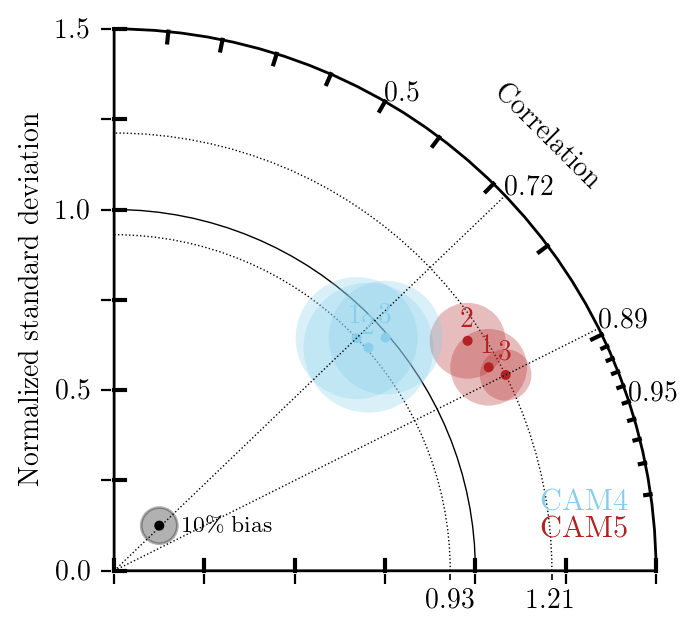

In [60]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 3 (CALIPSO low- mid- and high-level cloud)

### Open files

In [61]:
og_cll_caliop = xr.open_dataset('%s/CALIPSO.CLDLOW_CAL.nc' % (og_dir))
og_clm_caliop = xr.open_dataset('%s/CALIPSO.CLDMED_CAL.nc' % (og_dir))
og_clh_caliop = xr.open_dataset('%s/CALIPSO.CLDHGH_CAL.nc' % (og_dir))

cam4_cll_caliop = xr.open_dataset('%s/CAM4.CLDLOW_CAL.nc' % (og_dir))
cam5_cll_caliop = xr.open_dataset('%s/CAM5.CLDLOW_CAL.nc' % (og_dir))

cam4_clm_caliop = xr.open_dataset('%s/CAM4.CLDMED_CAL.nc' % (og_dir))
cam5_clm_caliop = xr.open_dataset('%s/CAM5.CLDMED_CAL.nc' % (og_dir))

cam4_clh_caliop = xr.open_dataset('%s/CAM4.CLDHGH_CAL.nc' % (og_dir))
cam5_clh_caliop = xr.open_dataset('%s/CAM5.CLDHGH_CAL.nc' % (og_dir))

### Interpolate to observational grid

#### Bilinear interpolation is better, but doesn't produce as good of agreement with the 2012 Fig

In [62]:
cam4_cll_caliopf,rgdr = interp_like2D(cam4_cll_caliop,target=og_cll_caliop)
cam5_cll_caliopf,_ = interp_like2D(cam5_cll_caliop,regridder=rgdr)

cam4_clm_caliopf,rgdr = interp_like2D(cam4_clm_caliop,target=og_clm_caliop)
cam5_clm_caliopf,_ = interp_like2D(cam5_clm_caliop,regridder=rgdr)

cam4_clh_caliopf,rgdr = interp_like2D(cam4_clh_caliop,target=og_clh_caliop)
cam5_clh_caliopf,_ = interp_like2D(cam5_clh_caliop,regridder=rgdr)

#### Nearest neighbor interpolation best reproduces the original figure

In [69]:
cam4_cll_caliopf = cam4_cll_caliop.interp_like(og_cll_caliop,method='nearest')
cam5_cll_caliopf = cam5_cll_caliop.interp_like(og_cll_caliop,method='nearest')

cam4_clm_caliopf = cam4_clm_caliop.interp_like(og_clm_caliop,method='nearest')
cam5_clm_caliopf = cam5_clm_caliop.interp_like(og_clm_caliop,method='nearest')

cam4_clh_caliopf = cam4_clh_caliop.interp_like(og_clh_caliop,method='nearest')
cam5_clh_caliopf = cam5_clh_caliop.interp_like(og_clh_caliop,method='nearest')

#### Prep and plot

In [70]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDLOW_CAL': og_cll_caliop['CLDLOW_CAL'],
        'CLDMED_CAL': og_clm_caliop['CLDMED_CAL'],
        'CLDHGH_CAL': og_clh_caliop['CLDHGH_CAL'],
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLDLOW_CAL':[cam4_cll_caliopf,cam5_cll_caliopf],
               'CLDMED_CAL':[cam4_clm_caliopf,cam5_clm_caliopf],
               'CLDHGH_CAL':[cam4_clh_caliopf,cam5_clh_caliopf]}
testcolors = ('SkyBlue','Firebrick')

In [71]:
varnames = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']

nvars = 3; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
#         print(type(obs_ds))
#         print(type(test_ds))
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

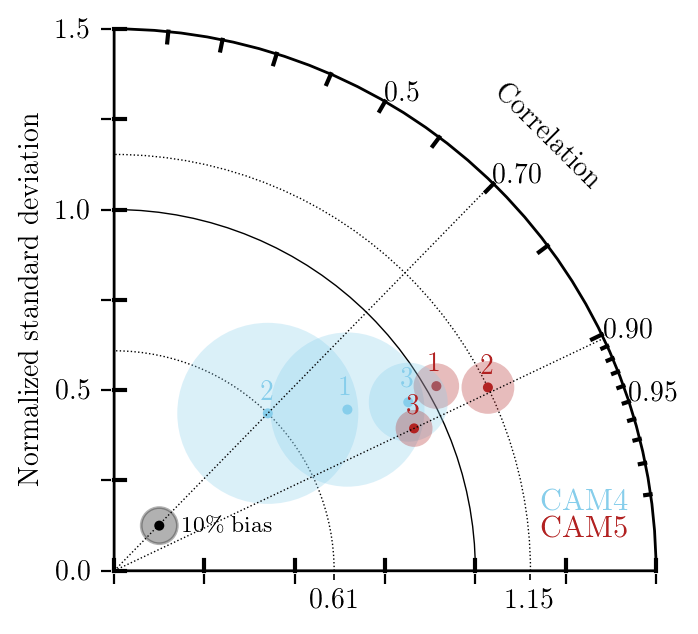

In [72]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 4 (MISR low-topped thick and MODIS high-topped thick cloud)

### Open files

In [73]:
og_clmisr = xr.open_dataset('%s/MISR.CLDLOW_THICK_MISR.nc' % (og_dir))
og_clmodis = xr.open_dataset('%s/MODIS.CLDHGH_THICK_MODIS.nc' % (og_dir))

cam4_clmisr = xr.open_dataset('%s/CAM4.CLDLOW_THICK_MISR.nc' % (og_dir))
cam5_clmisr = xr.open_dataset('%s/CAM5.CLDLOW_THICK_MISR.nc' % (og_dir))

cam4_clmodis = xr.open_dataset('%s/CAM4.CLDHGH_THICK_MODIS.nc' % (og_dir))
cam5_clmodis = xr.open_dataset('%s/CAM5.CLDHGH_THICK_MODIS.nc' % (og_dir))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLMISR' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLDLOW_THICK_MISR' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLMODIS' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLDHGH_THICK_MODIS' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_time

### Interpolate to observational grid

#### Bilinear interpolation is better, but doesn't produce as good of agreement with the 2012 Fig

In [74]:
cam4_clmisrf,rgdr = interp_like2D(cam4_clmisr,target=og_clmisr)
cam5_clmisrf,_ = interp_like2D(cam5_clmisr,regridder=rgdr)

cam4_clmodisf,rgdr = interp_like2D(cam4_clmodis,target=og_clmodis)
cam5_clmodisf,_ = interp_like2D(cam5_clmodis,regridder=rgdr)

#### Nearest neighbor interpolation best reproduces the original figure

In [78]:
cam4_clmisrf = cam4_clmisr.interp_like(og_clmisr,method='nearest')
cam5_clmisrf = cam5_clmisr.interp_like(og_clmisr,method='nearest')

cam4_clmodisf = cam4_clmodis.interp_like(og_clmodis,method='nearest')
cam5_clmodisf = cam5_clmodis.interp_like(og_clmodis,method='nearest')

#### Set-up

In [79]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDLOW_THICK_MISR': og_clmisr['CLDLOW_THICK_MISR'], # these have to be dataarrays, not datasets
        'CLDHGH_THICK_MODIS': og_clmodis['CLDHGH_THICK_MODIS'],
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLDLOW_THICK_MISR':[cam4_clmisrf,cam5_clmisrf],'CLDHGH_THICK_MODIS':[cam4_clmodisf,cam5_clmodisf]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [80]:
varnames = ['CLDLOW_THICK_MISR','CLDHGH_THICK_MODIS']

nvars = 2; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

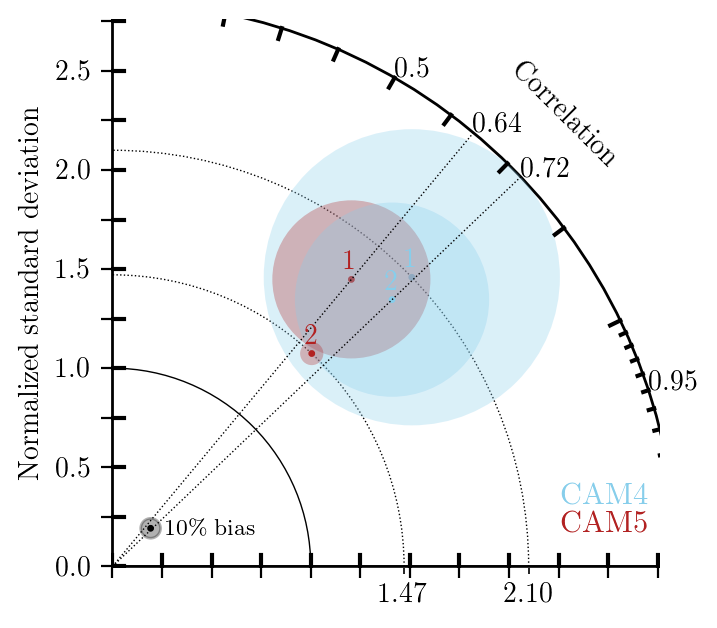

In [77]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

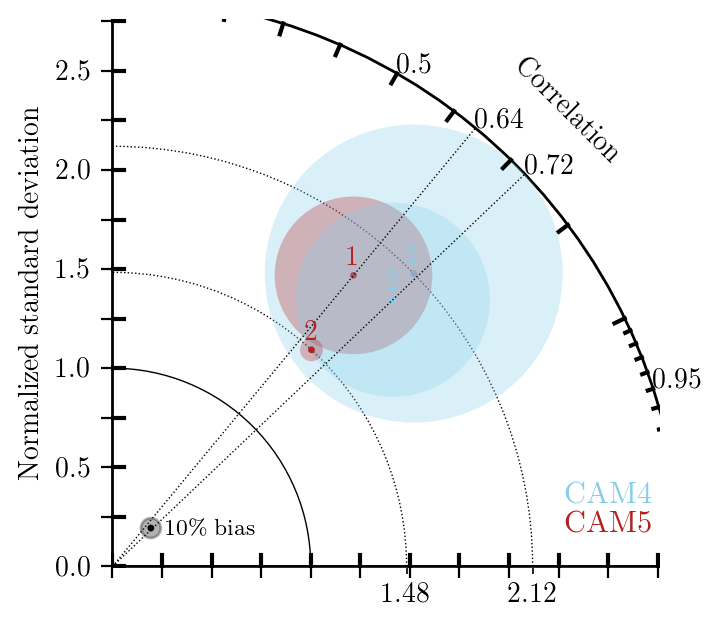

In [81]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False